## Block 6 chapter 3

In [1]:
"""Bayesian way"""
import arviz as az
import stan
import nest_asyncio
nest_asyncio.apply()

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

## Stanコードを書いてみる

ローカルレベルモデルの実装

$\mu_t = \mu_{t-1} + w_t, \quad w_t \sim N(0, \sigma_w^2)$ ・・・状態方程式<br>
$w_t$: 過程誤差<br>
(もしくは，$\mu_t \sim N(\mu_{t-1}, \sigma_w^2)$でも状態方程式を表せる)

$y_t = \mu_t + v_t, \quad v_t \sim N(0, \sigma_v^2)$ ・・・観測方程式<br>
$v_t$: 観測誤差<br>
(もしくは，$y_t \sim N(\mu_t, \sigma_v^2)$でも状態方程式を表せる)

ただし，$\mu_1 \sim N(\mu_0, \sigma_w^2)$．$\mu_0$は状態の初期値．

In [2]:
# data
n_sample = 100 # number of samples
y = np.zeros(n_sample)

# parameters
mu_zero = 100 # initial value of state
mu = np.zeros(n_sample)
s_w = 1000 # variance of process error (sigma_w)
s_v = 5000 # variance of observation error (sigma_v)

y.sum(), mu.sum()

(0.0, 0.0)

## Make model

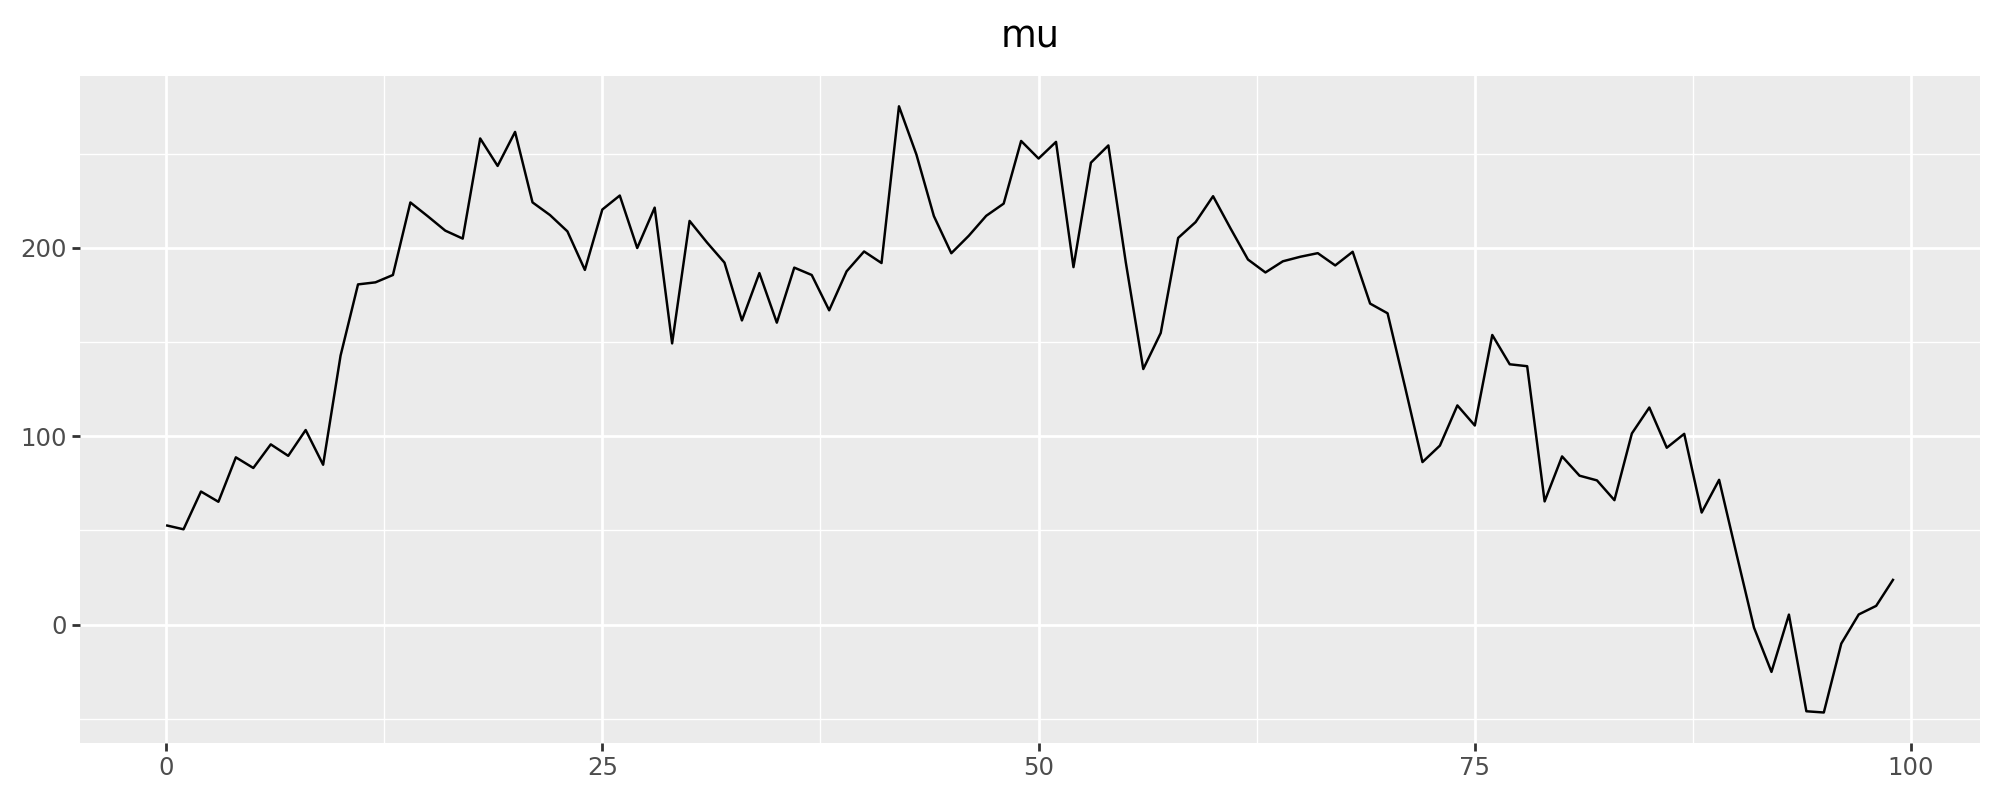

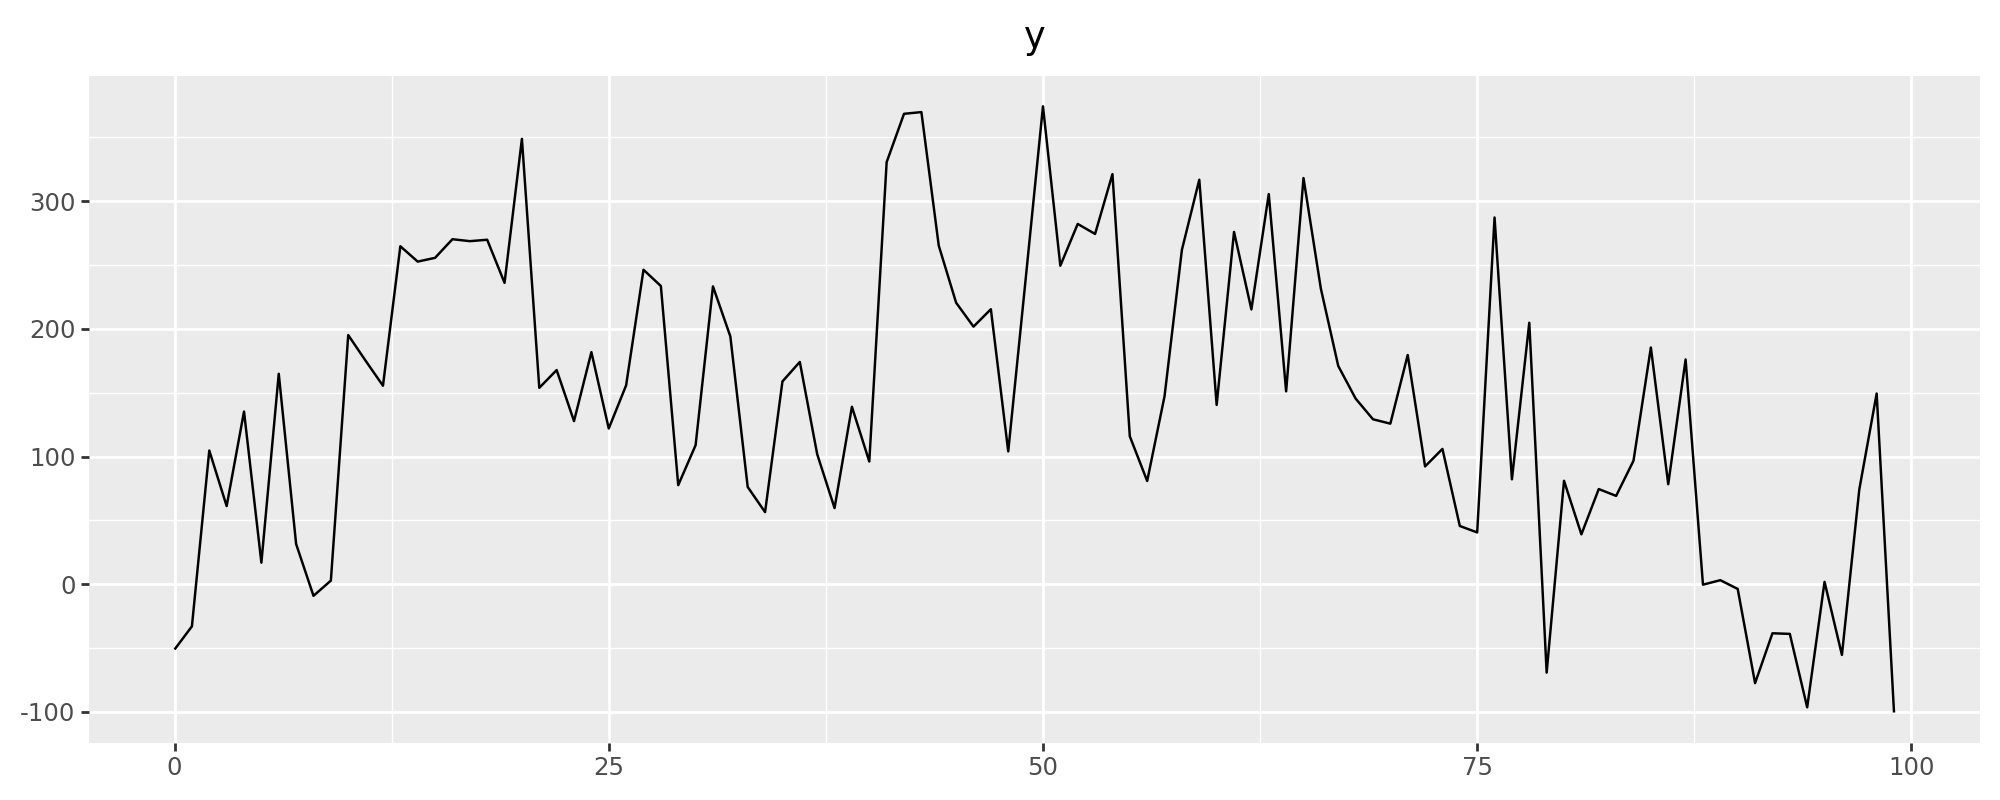

In [3]:
mu[0] = np.random.normal(loc=mu[0], scale=np.sqrt(s_w), size=1)

# equation of observation
for i in range(1, n_sample):
    mu[i] = np.random.normal(loc=mu[i-1], scale=np.sqrt(s_w), size=1)

# equation of state
for i in range(0, n_sample):
    y[i] = np.random.normal(loc=mu[i], scale=np.sqrt(s_v), size=1)

gg1 = (
    ggplot()
    + geom_line(aes(x=range(len(mu)), y=mu))
    + theme(figure_size=(10, 4))
    + labs(title="mu")
)
gg2 = (
    ggplot()
    + geom_line(aes(x=range(len(y)), y=y))
    + theme(figure_size=(10, 4))
    + labs(title="y")
)
print(gg1, end="")
print(gg2, end="")

In [8]:
df = {"n_sample": n_sample, "y": y}
with open("6-3.stan", "r") as fstan:
    posterior = stan.build(fstan.read(), data=df)
fit = posterior.sample(num_chains=4, num_samples=1000)
# eta = fit["eta"]  # array with shape (8, 4000)
# df = fit.to_frame()  # pandas `DataFrame, requires pandas

Building...



Building: 11.8s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   3% (203/8000)
Sampling:   9% (702/8000)
Sampling:  13% (1001/8000)
Sampling:  38% (3000/8000)
Sampling:  60% (4800/8000)
Sampling:  79% (6300/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transi

AssertionError: eta

In [9]:
fit

<stan.Fit>
Parameters:
    mu_zero: ()
    mu: (100,)
    s_w: ()
    s_v: ()
Draws: 4000